In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams
from scipy import integrate
import scipy as sc
from funcs import *
from numpy.linalg import norm
from numpy.random import normal, permutation, seed
from scipy.integrate import odeint
np.set_printoptions(precision=3, suppress=True)
%matplotlib notebook
## Python 3.11.4

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["CMU"],
})

- For $\rho = \mu<1$, converges to the origin, where there's a pitchfork bifuraction
- Hopf bifurcation at $\mu = 24.7...$
- Homoclinic bifurcation at $\mu = 13.926..$
- For sufficiently large $\mu > 313$, trajectories will settle down to a stable limit cycle


In [2]:
def lorenz(X, mu):
    x, y, z = X
    return [sigma*(y-x),
            x*(mu-z)-y,
            x*y-beta*z]

beta = 8/3
sigma = 10

# Generate training data
tf = 75
dt = 0.001
t_train = np.arange(0, tf, dt)

new_step = int(tf/dt)

mu_stable = np.arange(16, 24, 1)         # BEFORE BIF
mu_unstable = np.arange(25, 29, 1)               # AFTER BIF
# mu_unstable = np.array([350, 352, 354, 356])               # AFTER BIF

n_ics = mu_stable.size + mu_unstable.size  # *2
x_train = [np.zeros((t_train.size, 4)) for i in range(n_ics)]
ic_idx = 0

pts_eq = np.zeros((mu_stable.size*2, 4))
x0_train = (30, -30, 50)

i_eq = 0 
for mu in mu_stable:
    
    x = odeint(lambda x, t: lorenz(x, mu), x0_train, t_train)
    x_train[ic_idx][:, :-1] = x 
    x_train[ic_idx][:, -1] = mu
    
    pts_eq[i_eq, 0:2] = np.sqrt(beta*(mu-1))
    pts_eq[i_eq+1, 0:2] = -np.sqrt(beta*(mu-1))
    
    pts_eq[i_eq, 2] = mu-1
    pts_eq[i_eq+1,2] = mu-1
    
    pts_eq[i_eq, -1] = mu
    pts_eq[i_eq+1, -1] = mu
    
    ic_idx += 1
    i_eq += 2

for mu in mu_unstable:
    x = odeint(lambda x, t: lorenz(x, mu), x0_train, t_train, rtol=1e-10)
    x_train[ic_idx][:, :-1] = x
    x_train[ic_idx][:, -1] = mu
    ic_idx += 1

<IPython.core.display.Javascript object>


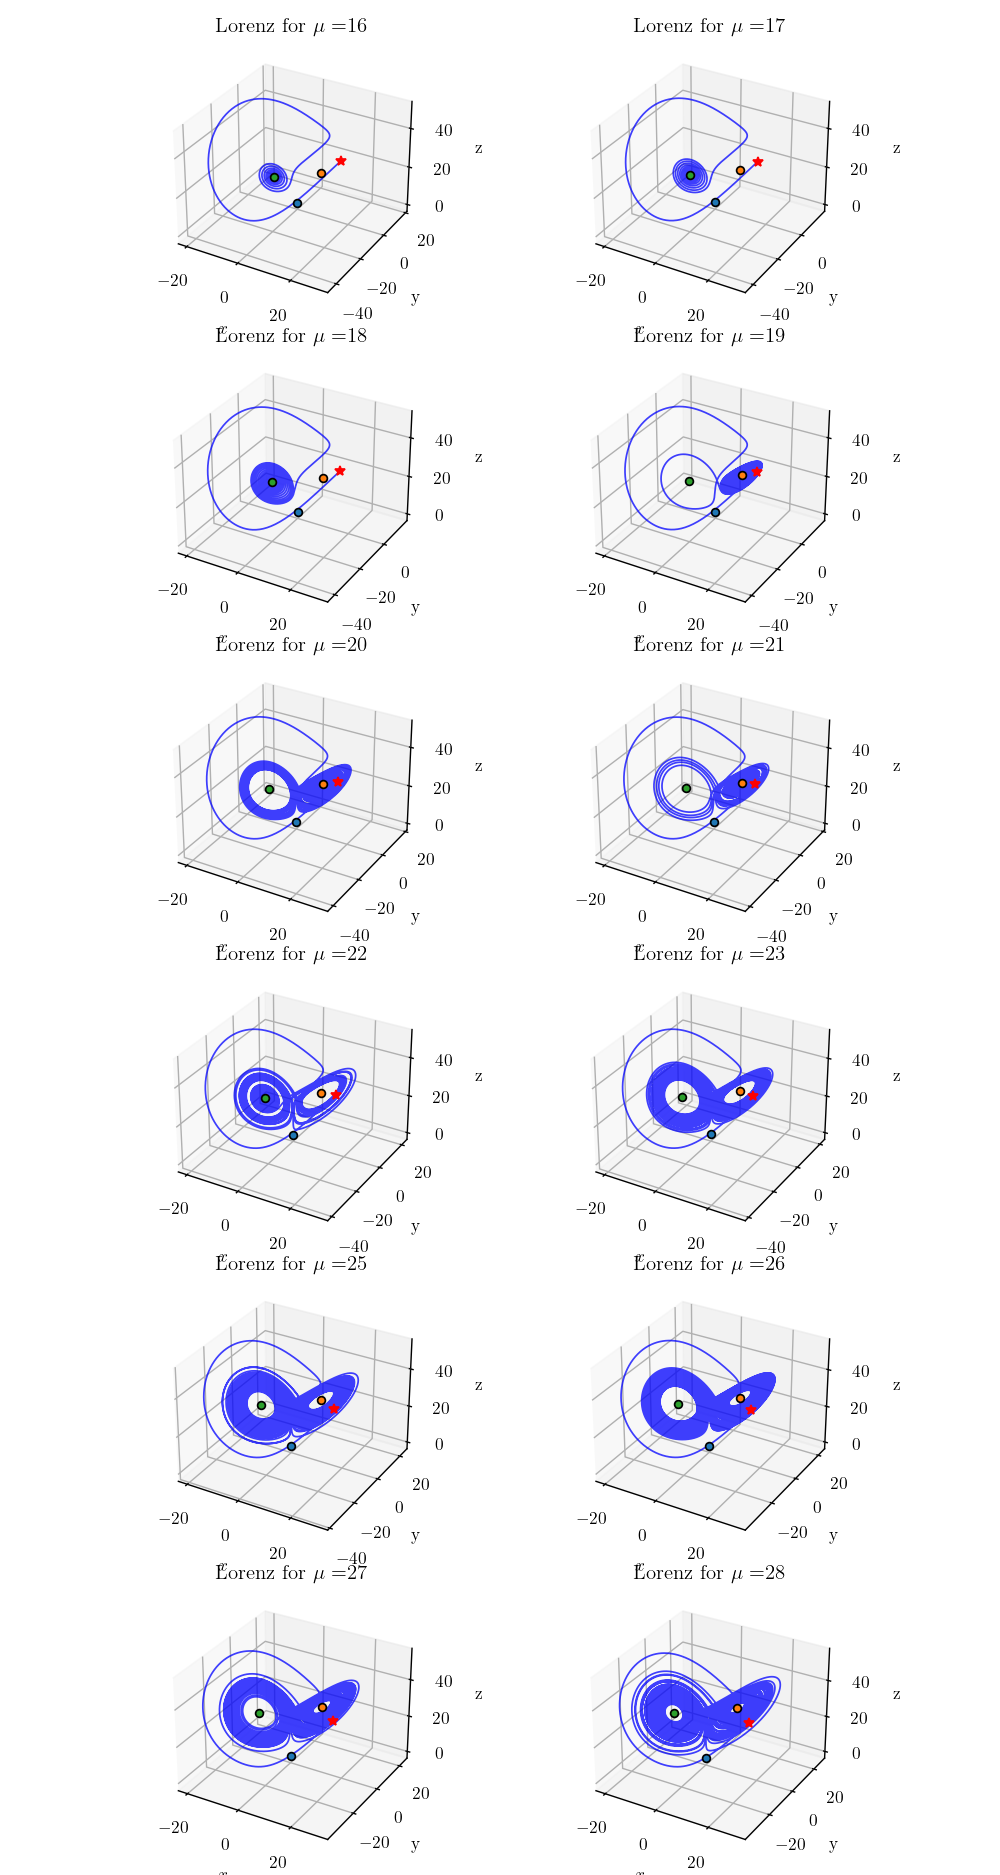

In [3]:
plot_kws = dict(alpha=0.75, linewidth=1)
fig, axes = plt.subplots(6, 2, figsize=(8, 15), subplot_kw={'projection': '3d'})

for i, ax in zip(range(n_ics), axes.flat):
    rho = np.r_[mu_stable, mu_unstable][i] 
    ax.plot(x_train[i][:, 0], x_train[i][:, 1], x_train[i][:, 2], "b", **plot_kws)
    ax.plot(x_train[i][0, 0], x_train[i][0, 1], x_train[i][0, 2], "*r")   # Initial condition
    ax.scatter(0, 0, 0, "ok", edgecolors='k')  # Origin
    ax.scatter(np.sqrt(beta*(rho-1)),
               np.sqrt(beta*(rho-1)), rho-1,
               "or", edgecolors='k')
    ax.scatter(-np.sqrt(beta*(rho-1)),
               -np.sqrt(beta*(rho-1)), rho-1,
               "or", edgecolors='k')
    ax.set(title="Full Simulation", xlabel="$x$", ylabel="y", zlabel="z")
    ax.set_title('Lorenz for $\mu = $' + str(np.r_[mu_stable, mu_unstable][i]), fontsize=12)

plt.tight_layout()
plt.show()

In [4]:
'''
CONCATENATE DATA
'''
x_real = np.array(x_train).reshape((n_ics*t_train.size, 4))
t_real = np.array(list(t_train)*n_ics)

x_real.shape, t_real.shape, new_step

((900000, 4), (900000,), 75000)

In [5]:
def mysindy2(X, t, lamb, polyorder, normalize=False):
    '''
    Applies a least-squared-sequential-threshholded SINDy algorithm to a matrix of spatial derivatives
    
    Input:
    
    X: Concatenated column-vector-matrix of each spatial data vector. Array type
    t: Column vector with the time of data acquisition. 
    lamb: Sparsity knob
    polyorder: order of the maximum polynomial for the library.
    
    Output:
    
    Column-vector-matrix with each constant of the respective polynomial term
    '''
    
    dims = X.shape[1]  # Number of equations
    vals = X.shape[0]     # Number of elements in each dim
    
    # --> Initialize the return array.
    dX = deriv4_time(X, t)
    
    THETA = PolynomialFeatures(polyorder)
    variable_names = THETA.fit(X).get_feature_names_out(['x', 'y', 'z', 'u'][0:dims])
    THETA = THETA.fit_transform(X)
    
    if normalize == True:
    
        #NORMALIZE COLUMNS
        THETAp = np.zeros_like(THETA)
        norms = np.zeros(THETA.shape[1])
        for i in range(THETA.shape[1]):
            norms[i] = np.max(THETA[:, i])
            THETAp[:, i] = THETA[:, i]/np.max(THETA[:, i])  ############################################
        THETA = THETAp

        # Initial guess
        CHI = np.linalg.lstsq(THETA, dX, rcond=None)[0]

        # Seq. Threshholding    
        for k in range(5):
            for i in range(dims):                        # n is state dimension
                smallinds = np.abs(CHI[:,i]) < np.max(np.abs(CHI[:,i]))*lamb   # Find small coefficients. This returns a boolean array
                CHI[smallinds, i] = 0                             # add threshold. CHI must be an array for this to work
                biginds = smallinds == 0           # == False
                # Regress dynamics onto remaining terms to find sparse Xi
                CHI[biginds, i] = np.linalg.lstsq(THETA[:, biginds], dX[:, i], rcond=None)[0]


        for i in range(dims):
            CHI[:, i] = CHI[:, i]/norms
    
    else:
        # Initial guess
        CHI = np.linalg.lstsq(THETA, dX, rcond=None)[0]

        # Seq. Threshholding    
        for k in range(19):
            for i in range(dims):                        # n is state dimension
                smallinds = np.abs(CHI[:,i]) < np.max(np.abs(CHI[:,i]))*lamb   # Find small coefficients. This returns a boolean array
                CHI[smallinds, i] = 0                             # add threshold. CHI must be an array for this to work
                biginds = smallinds == 0           # == False
                # Regress dynamics onto remaining terms to find sparse Xi
                CHI[biginds, i] = np.linalg.lstsq(THETA[:, biginds], dX[:, i], rcond=None)[0]
    
    return CHI, variable_names, lamb, THETA

### Importo mysindy2 para agregarle las 4 variables

In [6]:
# true_dynamics_4_lorenz = mysindy2(x_real, t_real, 0.01, 4, normalize=True)[0]

# # Save the array to a file
# np.save('true_dynamics_4_lorenz.npy', true_dynamics_4_lorenz)

# # Load the array from the file
true_dynamics_4 = np.load('true_dynamics_4_lorenz.npy')
true_dynamics_4[:20]

array([[  0.   ,   0.   ,   0.   ,  -0.   ],
       [-10.   ,   0.   ,   0.   ,  -0.   ],
       [ 10.   ,  -1.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,  -2.667,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   1.   ,   0.   ],
       [  0.   ,  -1.   ,   0.   ,   0.   ],
       [  0.   ,   1.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,  -0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,  -0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ]])

In [7]:
n_est = 70000  # consideramos que desde aca es estacionario antes era 7000

limit_cycle_start = mu_stable.size  # 8

'''
CREATE STATIONARY DATA ARRAYS
'''
x_est = est(x_real[new_step*limit_cycle_start:, :], n_est, new_step, n_ics-limit_cycle_start)
t_est = np.array(list(t_real[n_est:new_step])*(n_ics-limit_cycle_start))

In [8]:
T = 9
n_trans = 500
few_X = trans(x_train[T], n_trans, new_step, 1)
few_t = trans(t_train.reshape((new_step, 1)), n_trans, new_step, 1)

<IPython.core.display.Javascript object>


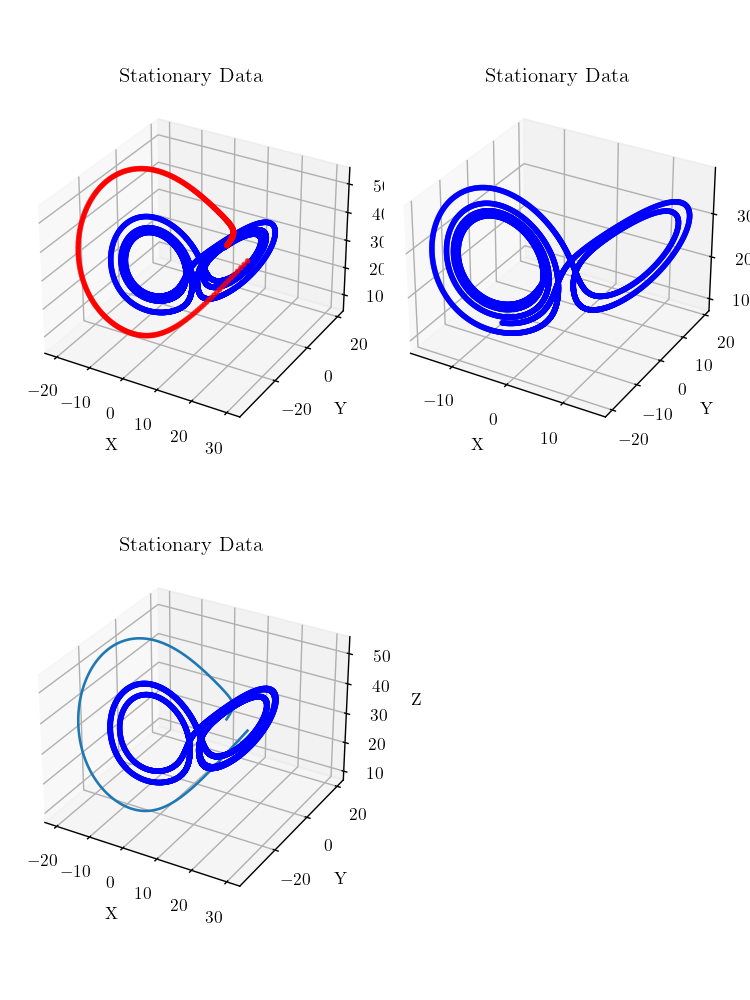

In [9]:
fig = plt.figure(figsize=(6, 8))
for i in range(mu_unstable.size - 1):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.scatter(x_est[i*(new_step-n_est):(i+1)*(new_step-n_est), 0],
               x_est[i*(new_step-n_est):(i+1)*(new_step-n_est), 1],
               x_est[i*(new_step-n_est):(i+1)*(new_step-n_est), 2], c='blue', alpha=0.7, s=5)
    ax.scatter(few_X[i*(new_step-n_est):(i+1)*(new_step-n_est), 0],
               few_X[i*(new_step-n_est):(i+1)*(new_step-n_est), 1],
               few_X[i*(new_step-n_est):(i+1)*(new_step-n_est), 2], c='red', alpha=0.7, s=5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Stationary Data')
    
ax.plot(few_X[:, 0], few_X[:, 1], few_X[:, 2])

plt.tight_layout()
plt.show()

In [10]:
'''
OBTAIN [HIGH FIDELITY] POINTS FOR CONSTRAINTS                                           ADD NOISE TO THE EQUILIBRIA HERE
'''
space = 200 # antes era 20

sampling = BurstSampling(x_est, t_est, 5, space)
ptss_dx = sampling[0]
ptss = sampling[1]
t_pts = sampling[2]
ptss_total = sampling[3]
t_total = sampling[4]

n_ptss = int(ptss.shape[0]/len(mu_unstable))

<IPython.core.display.Javascript object>


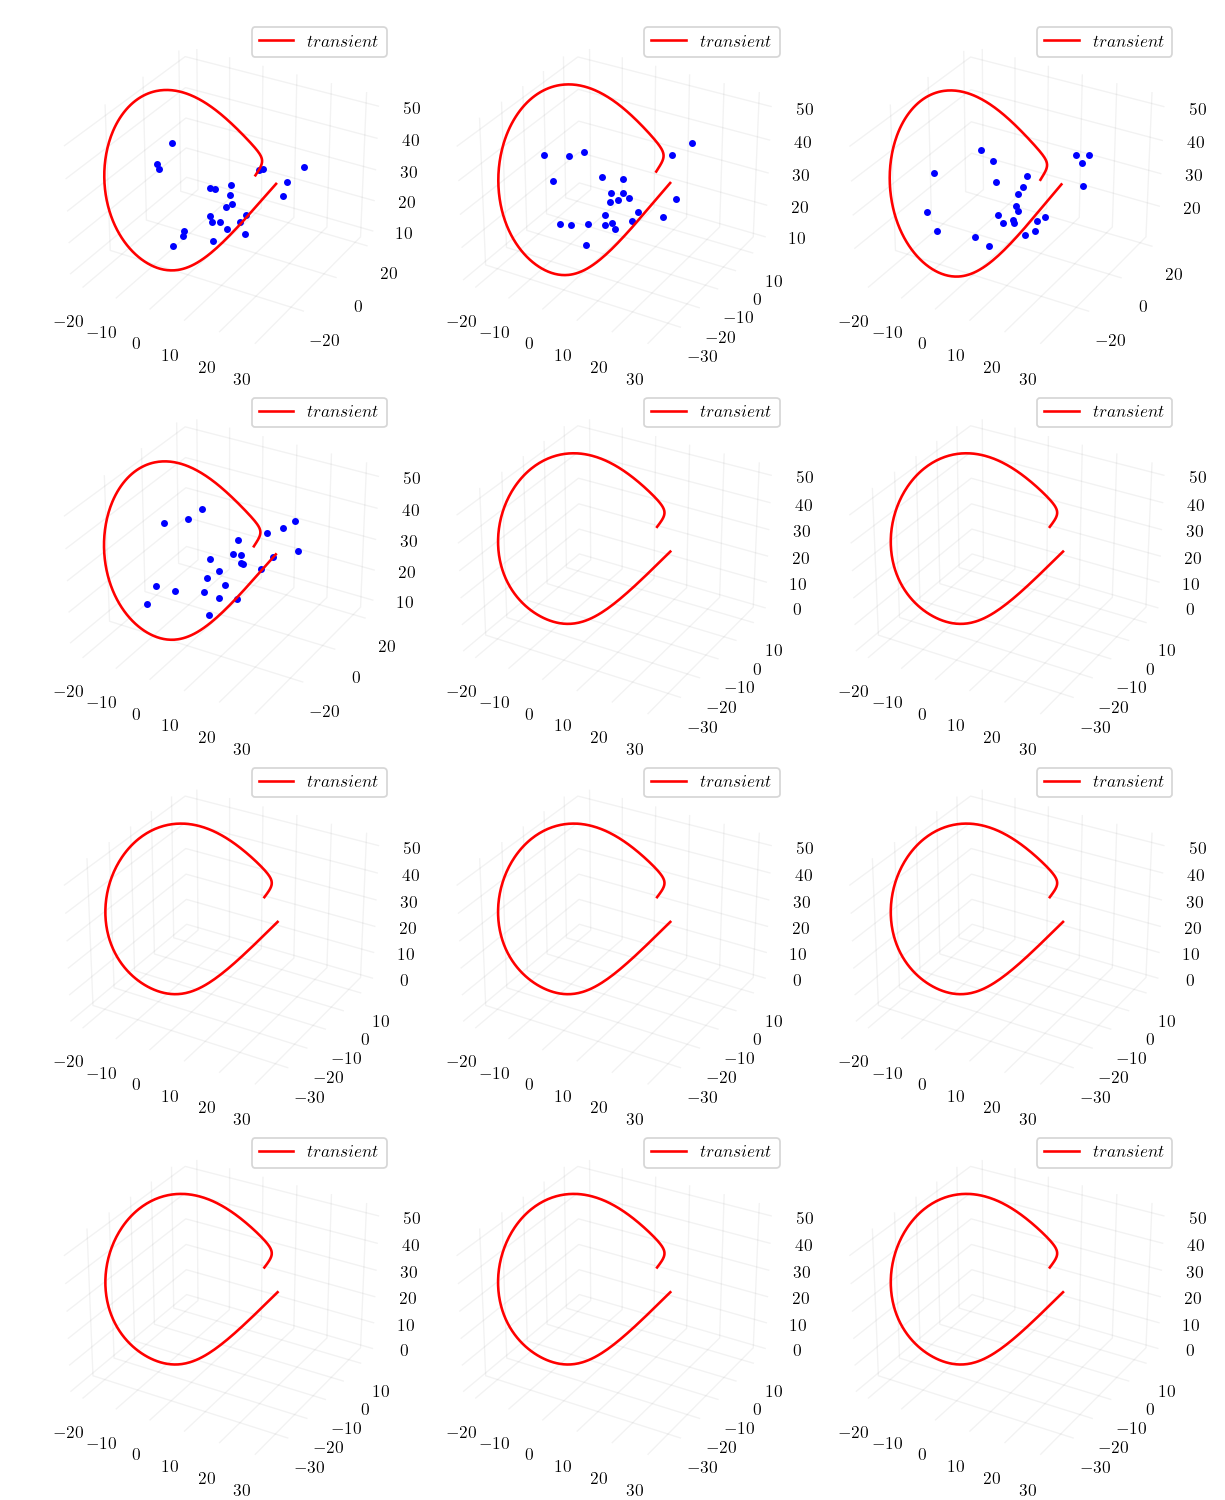

In [11]:
num_plots = n_ics
rows = 4  # Define the number of rows in the subplot grid
cols = (num_plots + rows - 1) // rows  # Calculate the number of columns needed

fig = plt.figure(figsize=(9.8, 12))  # Set the overall figure size

idx = 0
for k in range(num_plots):
    plt.rcParams['grid.color'] = (0.05, 0.05, 0.05, 0.05)

    # Create a new subplot for each iteration
    ax = fig.add_subplot(rows, cols, k + 1, projection='3d')

    tuples = (0., 0., 0., 0.)
    ax.xaxis.line.set_color(tuples)
    ax.yaxis.line.set_color(tuples)
    ax.zaxis.line.set_color(tuples)
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = (0, 0, 0)
        axis._axinfo['tick']['inward_factor'] = 0.0
        axis._axinfo['tick']['outward_factor'] = 0.0
        axis.set_pane_color((1, 1, 1))

    ax.tick_params(axis='x', size=30)
    ax.tick_params(axis='y', size=30)
    ax.tick_params(axis='z', size=30)
    
    ax.plot(ptss[idx*n_ptss:(idx+1)*n_ptss, 0], ptss[idx*n_ptss:(idx+1)*n_ptss, 1],
            ptss[idx*n_ptss:(idx+1)*n_ptss, 2], ".b")
    ax.plot(few_X[:, 0], few_X[:, 1], few_X[:, 2], "r", label=f'$transient$')
    idx += 1
    plt.legend()

plt.tight_layout()  # Adjust the spacing between subplots

plt.show()

In [12]:
def musindy(X, t, polyorder, lamb, alpha, dX):
    '''
    Returns a sequential threshholded sparse regression by applying constrained-least-squares regression recursively
    to a pre-normalized candidate library matrix by its maximum value.

    polyorder: Polynomial Order

    '''
    vals, dims = X.shape  # dims --> number of columns

#     dX = deriv4_time(X, t)

    library = PolynomialFeatures(polyorder)
    THETA = library.fit_transform(X)
    variable_names = library.fit(X[:dims, :]).get_feature_names_out(['x1', 'y1', 'x2', 'y2', 'u'][0:dims])

    l = THETA.shape[1]

    # Initialize constraints -------------------------------------------------------------------------
    n_constraints = ptss.shape[0] # + pts_eq.shape[0] 

    C = np.zeros((n_constraints, l))
    d = np.zeros((n_constraints, dims))

    idx = 0  # Index for row of C and element of vector d

    for p in ptss:         
        arr = library.fit_transform(np.array([p])).flatten()
        C[idx, :] = arr
        d[idx] = ptss_dx[idx, :]
        idx += 1

#     for p in pts_eq:         
#         arr = library.fit_transform(np.array([p])).flatten()
#         C[idx, :] = arr
#         idx += 1

    # -------------------------------------------------------------------------------------------------
    THETA_C = np.r_[THETA, np.sqrt(alpha)*C]
    dX = np.r_[dX, np.sqrt(alpha)*d]

    # -------------------------------------------------------------------------------------------------
    #NORMALIZE COLUMNS
    THETAp = np.zeros_like(THETA_C)
    norms = np.zeros(THETA_C.shape[1])
    for i in range(THETA_C.shape[1]):
        
        norms[i] = np.max(np.abs(THETA_C[:, i]))
        THETAp[:, i] = THETA_C[:, i]/np.max(np.abs(THETA_C[:, i]))
        
    THETA = THETAp
    # -------------------------------------------------------------------------------------------------

    # Initial guess
    CHI = np.linalg.pinv(THETA)@dX

    # Seq. Threshholding
    for k in range(5):
        for i in range(dims):
            lamb2 = np.max(np.abs(CHI[:, i]))*lamb
            smallinds = np.abs(CHI[:, i]) < lamb2
            CHI[smallinds, i] = 0  # Mask
            biginds = smallinds == 0
            CHI[biginds, i] = np.linalg.pinv(THETA[:, biginds])@dX[:, i]

    for i in range(dims):
        CHI[:, i] = CHI[:, i]/norms

    return CHI, variable_names, polyorder

In [38]:
LAMBDA = 0.01
ALPHA = 1e14

In [40]:
coefw = musindy(few_X, few_t, 4, LAMBDA, ALPHA, deriv4_time(few_X, few_t))  # 1e14
coefw[0][:25, :]

array([[  0.   ,   0.   ,   0.   ,   0.   ],
       [-10.   ,   0.   ,   0.   ,   0.   ],
       [ 10.   ,  -1.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,  -2.667,   0.   ],
       [  0.   ,   0.   ,   0.   ,  -0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   1.   ,   0.   ],
       [  0.   ,  -1.   ,   0.   ,   0.   ],
       [  0.   ,   1.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  

In [41]:
coef = musindy(few_X, few_t, 4, LAMBDA, 1, deriv4_time(few_X, few_t))
coef[0][:25]

array([[  0.   ,   0.   ,   0.   ,   0.   ],
       [-10.   ,   0.   ,   0.   ,  -0.   ],
       [ 10.   ,  -1.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,  -2.667,  -0.   ],
       [  0.   ,   0.   ,   0.   ,  -0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   1.   ,   0.   ],
       [  0.   ,  -1.   ,   0.   ,   0.   ],
       [  0.   ,   1.   ,   0.   ,  -0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,  -0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,  -0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,   0.   ],
       [  

## NOISE ADDING

$$\frac{\sigma}{||u||}_{rms}$$

In [42]:
'''
OBTAIN [HIGH FIDELITY] POINTS FOR CONSTRAINTS                                           ADD NOISE TO THE EQUILIBRIA HERE
'''
eps2 = 0.0
signal_power = np.sqrt(np.mean(x_est**2))
sigma2 = eps2*signal_power

In [43]:
grid_length = 11
seeds = np.arange(0, (grid_length**2)*1000+1, 1)*10

Ec_14_final = []
Ec_1_final = []
Ec_30_final = []

Em_14_final = []
Em_1_final = []
Em_30_final= []

rango_ruido = np.linspace(0, 1, grid_length)
rango_l = np.linspace(n_trans, 5, grid_length, dtype=int)  # 500

seed_idx = 0
for noise in rango_ruido:
    Ec_14_inicial = []
    Ec_1_inicial = []
    Ec_30_inicial= []
    
    Em_14_inicial = []
    Em_1_inicial = []
    Em_30_inicial = []
    for largo in rango_l:
        for i in range(500):
            seed(seeds[seed_idx])

            '''
            CHOOSE 1 TRANSIENT FOR THE REGRESSION                                             ADD NOISE TO THE TRANSIENT HERE
            '''
            eps = noise
            sigma = eps*signal_power

            x_Trans_prior = few_X + np.c_[sigma * normal(size=(n_trans, 3)), np.zeros(n_trans)]# NO NOISE ON PARAMETERS
            t_Trans_prior = few_t
            dX_prior = deriv4_time(x_Trans_prior, t_Trans_prior)

            '''
            apply algorithm to decimated arrays
            '''
            data_length = largo
            mask = np.sort(permutation(np.arange(x_Trans_prior.shape[0]))[:data_length])

            x_Trans = x_Trans_prior[mask]
            t_Trans = t_Trans_prior[mask]
            dX = dX_prior[mask]

            coeffsw = musindy(x_Trans, t_Trans, 4, LAMBDA, ALPHA, dX)
            coeffs_OG = musindy(x_Trans, t_Trans, 4, LAMBDA, 1, dX)
            coeffs_30 = musindy(x_Trans, t_Trans, 4, 0.5, 1e9, dX)

            # ------------------------------------------------- MODEL ERROR --------------------------------

            Ec_14_inicial.append(norm(coeffsw[0]-true_dynamics_4, ord='fro')/norm(true_dynamics_4, ord='fro'))
            Ec_1_inicial.append(norm(coeffs_OG[0]-true_dynamics_4, ord='fro')/norm(true_dynamics_4, ord='fro'))
            Ec_30_inicial.append(norm(coeffs_30[0]-true_dynamics_4, ord='fro')/norm(true_dynamics_4, ord='fro'))

            # --------------------------------------------------- SUCCESS RATE ---------------------------------
            sparsity_true = (abs(true_dynamics_4) > 0.001)*1
            sparsity_w = (abs(coeffsw[0]) > 0.001)*1
            sparsity_OG = (abs(coeffs_OG[0]) > 0.001)*1
            sparsity_30 = (abs(coeffs_30[0]) > 0.001)*1
    
            if norm(sparsity_true - sparsity_w) < 1e-3:
                Em_14_inicial.append(1)
            else:
                Em_14_inicial.append(0)

            if norm(sparsity_true - sparsity_OG) < 1e-3:
                Em_1_inicial.append(1)
            else:
                Em_1_inicial.append(0)
                
            if norm(sparsity_true - sparsity_30) < 1e-3:
                Em_30_inicial.append(1)
            else:
                Em_30_inicial.append(0)

            seed_idx += 1

        Em_14_final.append(np.mean(Em_14_inicial))
        Em_1_final.append(np.mean(Em_1_inicial))
        Em_30_final.append(np.mean(Em_30_inicial))
        
        Ec_14_final.append(np.mean(Ec_14_inicial))
        Ec_1_final.append(np.mean(Ec_1_inicial))
        Ec_30_final.append(np.mean(Ec_30_inicial))

<IPython.core.display.Javascript object>


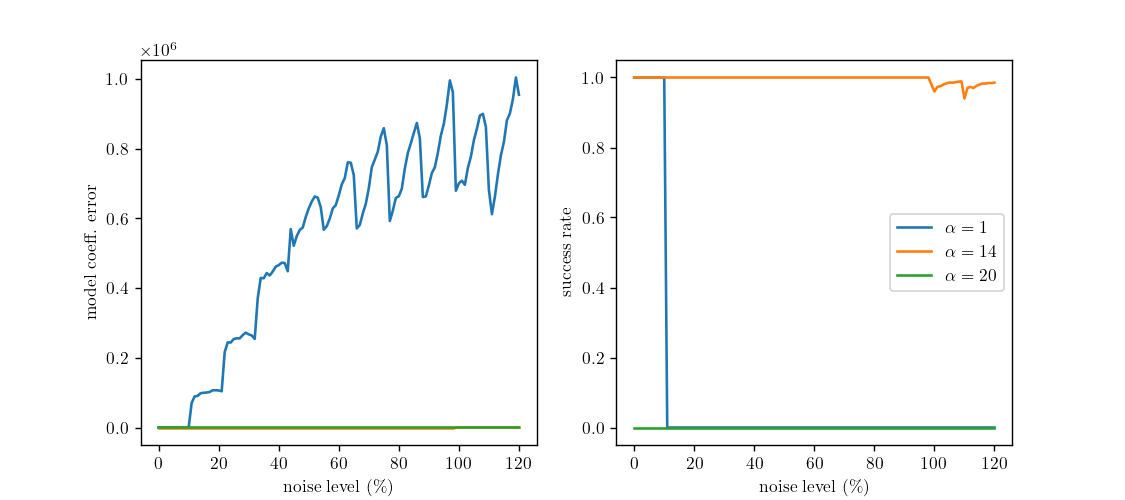

In [44]:
# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

# Plot the data for Ec_og0 and Ec_musindy0 on the first subplot
axs[0].plot(Ec_1_final, label='$\\alpha = 1$')
axs[0].plot(Ec_14_final, label='$\\alpha = 14$')
axs[0].plot(Ec_30_final, label='$\\alpha = 20$')
axs[0].set_xlabel('noise level (\%)')
axs[0].set_ylabel('model coeff. error')

# Plot the data for Em_og0 and Em_musindy0 on the second subplot
axs[1].plot(Em_1_final, label='$\\alpha = 1$')
axs[1].plot(Em_14_final, label='$\\alpha = 14$')
axs[1].plot(Em_30_final, label='$\\alpha = 20$')
axs[1].set_xlabel('noise level (\%)')
axs[1].set_ylabel('success rate')

# Show the plot
plt.legend()
plt.show()

In [45]:
EC_MUSINDY = np.zeros((len(rango_ruido), len(rango_l)))
EC_OG = np.zeros_like(EC_MUSINDY)
EC_30 = np.zeros_like(EC_MUSINDY)

EM_MUSINDY = np.zeros_like(EC_MUSINDY)
EM_OG = np.zeros_like(EC_MUSINDY)
EM_30 = np.zeros_like(EC_MUSINDY)


iii = 0
for i in range(len(rango_ruido)): #noise
    for j in range(len(rango_l)): #largo
        EC_MUSINDY[(len(rango_l)-1)-j, i] = Ec_14_final[iii]
        EC_OG[(len(rango_l)-1)-j, i] = Ec_1_final[iii]
        EC_30[(len(rango_l)-1)-j, i] = Ec_30_final[iii]
        EM_MUSINDY[(len(rango_l)-1)-j, i] = Em_14_final[iii]
        EM_OG[(len(rango_l)-1)-j, i] = Em_1_final[iii]
        EM_30[(len(rango_l)-1)-j, i] = Em_30_final[iii]
        iii += 1
        
# np.round(EC_MUSINDY, 2), np.round(Ec_musindy0, 2)
# np.round(EM_MUSINDY, 2), np.round(Em_musindy0, 2)

In [52]:
# from scipy.io import savemat, loadmat

# dicc = {'EC_OG': EC_OG,
#         'EC_MUSINDY': EC_MUSINDY,
#         'EM_OG': EM_OG,
#         'EM_MUSINDY': EM_MUSINDY    
#        }

# savemat('heat_data_lorenz.mat', dicc)

In [47]:
# from scipy.io import loadmat

# DF = loadmat('heat_data_hopf.mat')
# EC_OG = DF['EC_OG']
# EC_MUSINDY = DF['EC_MUSINDY']
# EM_OG = DF['EM_OG']
# EM_MUSINDY = DF['EM_MUSINDY']

<IPython.core.display.Javascript object>


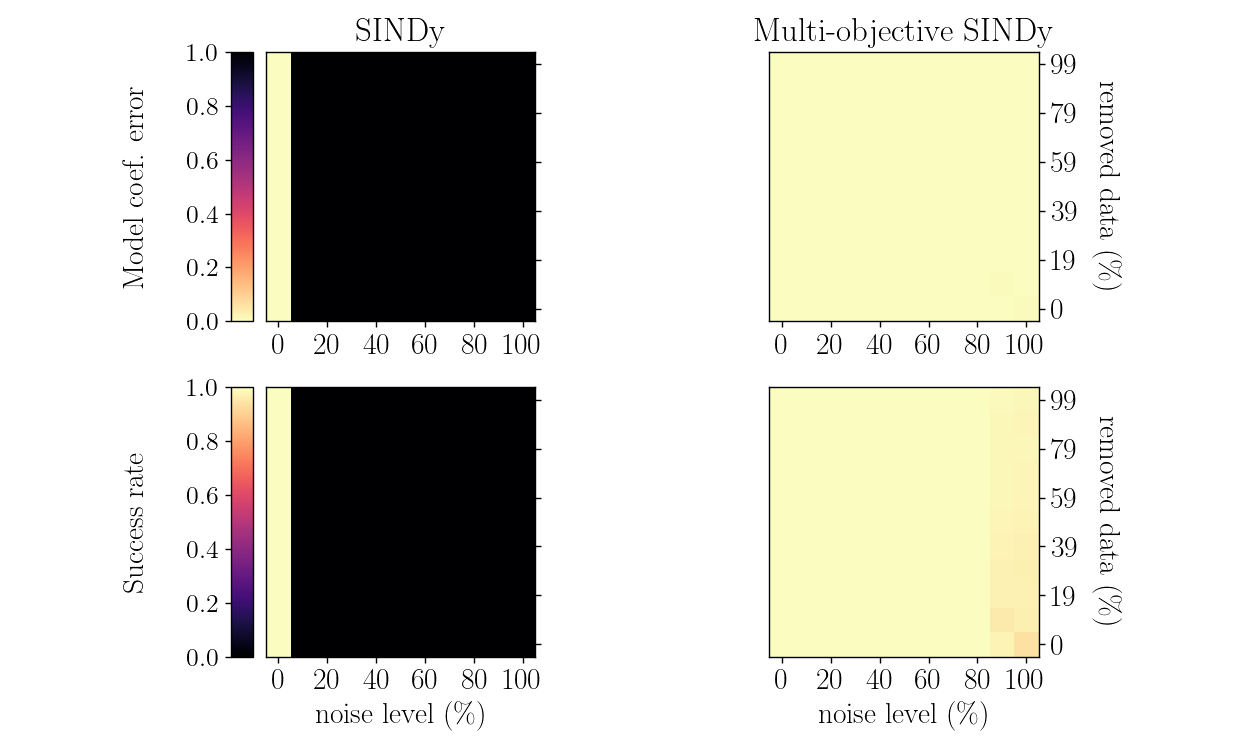

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(2, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [1, 1]})

vmin = 0
vmax = 1

xticks = np.round(np.linspace(rango_ruido[0], rango_ruido[-1], 6, endpoint=True) * 100)
yticks = np.linspace((1-rango_l[-1]/rango_l[0])*100, 0, 6, endpoint=True, dtype=int)

FTSIZE = 17

# Gráfico 1
im1 = axs[0, 0].imshow(EC_OG, cmap='magma_r', vmin=vmin, vmax=vmax)
axs[0, 0].set_title('SINDy', fontsize=FTSIZE+2)
axs[0, 0].set_xticks(range(0, len(rango_ruido) + 1, 2))
axs[0, 0].set_xticklabels(xticks.astype(int), fontsize=FTSIZE)  # Set x-axis tick labels as integers 
axs[0, 0].set_yticks(range(0, len(rango_ruido) + 1, 2))
axs[0, 0].set_yticklabels(yticks, fontsize=FTSIZE)
axs[0, 0].tick_params(axis='y', right=True, left=False, labelright=False, labelleft=False)
axs[0, 0].set_ylabel('Success rate', fontsize=FTSIZE, labelpad=20)

# Remove y-label of the leftmost plot
axs[0, 0].set_ylabel('')

axs[0, 1].tick_params(axis='y', right=True, left=False, labelright=True, labelleft=False)

# Gráfico 2
im2 = axs[0, 1].imshow(EC_MUSINDY, cmap='magma_r', vmin=vmin, vmax=vmax)
axs[0, 1].set_title('Multi-objective SINDy', fontsize=FTSIZE+2)
axs[0, 1].set_xticks(range(0, len(rango_ruido) + 1, 2))
axs[0, 1].set_xticklabels(xticks.astype(int), fontsize=FTSIZE)  # Set x-axis tick labels as integers
axs[0, 1].set_yticks(range(0, len(rango_ruido) + 1, 2))
axs[0, 1].set_yticklabels(yticks, fontsize=FTSIZE)
axs[0, 1].set_ylabel('removed data (\%)', fontsize=FTSIZE, rotation=270, labelpad=25)

# -----------------------------------------------------------------------------------------------------------------------

vmin2 = 0
vmax2 = 1

# Gráfico 4
im4 = axs[1, 0].imshow(EM_OG, cmap='magma', vmin=vmin2, vmax=vmax2)
axs[1, 0].set_xticks(range(0, len(rango_ruido) + 1, 2))
axs[1, 0].set_xticklabels(xticks.astype(int), fontsize=FTSIZE)  # Set x-axis tick labels as integers
axs[1, 0].set_yticks(range(0, len(rango_ruido) + 1, 2))
axs[1, 0].set_yticklabels(yticks, fontsize=FTSIZE)
axs[1, 0].tick_params(axis='y', right=True, left=False, labelright=False, labelleft=False)

# Gráfico 5
im5 = axs[1, 1].imshow(EM_MUSINDY, cmap='magma', vmin=vmin2, vmax=vmax2)
axs[1, 1].set_xticks(range(0, len(rango_ruido) + 1, 2))
axs[1, 1].set_xticklabels(xticks.astype(int), fontsize=FTSIZE)  # Set x-axis tick labels as integers
axs[1, 1].set_yticks(range(0, len(rango_ruido) + 1, 2))
axs[1, 1].set_yticklabels(yticks, fontsize=FTSIZE)
axs[1, 1].tick_params(axis='y', right=True, left=False, labelright=True, labelleft=False)

axs[1, 1].set_ylabel('removed data (\%)', fontsize=FTSIZE, rotation=270, labelpad=25)

# -----------------------------------------------------------------------------------------------------------------------

# Add x-axis labels to the bottom subplots
axs[1, 0].set_xlabel('noise level (\%)', fontsize=FTSIZE)
axs[1, 1].set_xlabel('noise level (\%)', fontsize=FTSIZE)

# Move y-axis labels to the right of the rightmost plot
axs[0, 1].yaxis.set_label_position("right")
axs[1, 1].yaxis.set_label_position("right")

# Add colorbars to the left of every row
divider1 = make_axes_locatable(axs[0, 0])
cax1 = divider1.append_axes("left", size="8%", pad='5%')
cax1.tick_params(labelsize=15)
cbar1 = plt.colorbar(im2, cax=cax1)
cbar1.set_label('Model coef. error', fontsize=17, labelpad=-75, rotation=90)
cbar1.ax.yaxis.set_ticks_position("left")

divider2 = make_axes_locatable(axs[1, 0])
cax2 = divider2.append_axes("left", size="8%", pad='5%')
cax2.tick_params(labelsize=15)
cbar2 = plt.colorbar(im4, cax=cax2)
cbar2.set_label('Success rate', fontsize=17, labelpad=-75, rotation=90)
cbar2.ax.yaxis.set_ticks_position("left")

# Ajustar el espaciado entre subtramas
plt.tight_layout()

# Mostrar el gráfico
plt.show()
# plt.savefig('lorenz_heatmap.pdf')

In [50]:
# theta_tr = np.zeros((7500*6, 35))
library_test = PolynomialFeatures(4)
theta_tr = library_test.fit_transform(trans(x_real, n_trans, new_step, n_ics))
theta_tr
theta_att = library_test.fit_transform(np.r_[pts_eq, ptss])
theta_att.shape

# library_test.fit(trans(x_real, n_trans, new_step, n_ics)).get_feature_names_out()

(116, 70)

In [51]:
import scipy.io

# n_att es el numero total de datos en atractores ~ 630

data_lorenz = {
             'x0': x0_train,
             'Mu': list(mu_stable) + list(mu_unstable),
             'mu_tr': few_X[0, -1],
             'r': [1, 1, 1, 1, 1, 1, n_ptss, n_ptss, n_ptss, n_ptss, n_ptss, n_ptss, n_ptss, n_ptss],
             'm': [n_trans]*12,
             'dt': dt,
             'X_tr': trans(x_real, n_trans, new_step, n_ics),
             'X_att': np.r_[pts_eq, ptss],
             't_att': t_pts,
             'X_dot_tr': deriv4_time(trans(x_real, n_trans, new_step, n_ics),
                                     trans(t_real.reshape((t_real.shape[0], 1)), n_trans, new_step, n_ics)),
             'X_dot_att': np.r_[np.zeros_like(pts_eq), ptss_dx],
             'Theta_tr': theta_tr,
             'Theta_att': theta_att,
             'theta': coeffsw[1],
             'lambda': [LAMBDA],
             'alpha_exp': str(ALPHA)
            }

scipy.io.savemat('data_lorenz.mat', data_lorenz)